  #                          Segmentation des clients du site E-Commerce Olist

Olist souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication.
L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs données personnelles anonymisées.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps (dans le but d'établir un contrat de maintenance).

Nous utilisererons donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires.

# Sommaire

1. Description des données
   
   1.1. Chargement des datasets
   
   1.2. Création des datasets étendus

2. Feature engineering en fonction du client

3. Exploration du dataset client

In [ ]:
def install_libraries(required={}) -> None:
    """
    Installation des bibliothèques manquantes
    https://stackoverflow.com/questions/44210656/
    """
    import sys
    import subprocess
    import pkg_resources
    installed = {pkg.key for pkg in pkg_resources.working_set}
    missing = set(required) - set(installed)
    if missing:
        print(f'missing libraries: {missing}')
        python = sys.executable
        subprocess.check_call([python, '-m', 'pip', 'install', *missing],
                              stdout=subprocess.DEVNULL)


required_libraries = {'numpy', 'pandas', 'matplotlib', 'seaborn',
                      'scipy', 'scikit-learn', 'statsmodels',
                      'missingno','yellowbrick',"lxml"}
install_libraries(required_libraries)

In [ ]:
# Librairies import
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import radians, cos, sin, asin, sqrt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Description des données

## Chargement des datasets

Nous allons charger tous les datasets pour en visualiser les informations principales :

### Les clients

In [ ]:
# root path for all dataset
drive= True
if drive == True:
  root_path= "/content/drive/MyDrive/olist/"
else:
  root_path = 'D:\\Downloads\\olist\\'

# olist_customers_dataset
customers = pd.read_csv(root_path + "olist_customers_dataset.csv")
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Les variables importantes du dataset :

* customer_id : Clé dans le dataset des commandes
* customer_unique_id : Identifiant unique du client
* customer_state : Etat du client

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


Le dataset ne comporte pas de valeurs nulles.

### Les données de géolocalisation

In [ ]:
# olist_geolocation_dataset
geolocation = pd.read_csv(root_path + "olist_geolocation_dataset.csv")
geolocation.head(5)

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [ ]:
geolocation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


Le fichier compte plus d'un million de lignes et pas de valeurs nulles. Ce fichier est lié au fichier clients grâce à la clé geolocation_zip_code_prefix. Regardons la description du fichier pour avoir un aperçu des étendues de Latitudes et Longitudes :

In [ ]:
geolocation.describe()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
count,1.000163e+06,1.000163e+06,1.000163e+06
mean,3.657417e+04,-2.117615e+01,-4.639054e+01
std,3.054934e+04,5.715866e+00,4.269748e+00
min,1.001000e+03,-3.660537e+01,-1.014668e+02
25%,1.107500e+04,-2.360355e+01,-4.857317e+01
50%,2.653000e+04,-2.291938e+01,-4.663788e+01
75%,6.350400e+04,-1.997962e+01,-4.376771e+01
max,9.999000e+04,4.506593e+01,1.211054e+02


### Les commandes clients

In [ ]:
# olist_orders_dataset
orders = pd.read_csv(root_path + "olist_orders_dataset.csv")
orders.head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Ce fichier regroupe les entêtes de commandes, identifiées par un order_id unique et rattaché à un client par le customer_id.

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


### Les articles

In [ ]:
# olist_order_items_dataset
order_items = pd.read_csv(root_path + "olist_order_items_dataset.csv")
order_items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Variables importantes du dataset regroupant les lignes de commande :

* order_id : Identifiant unique de la commande
* order_item_id : Identifiant séquentiel des items d'une même commande (lignes de commande)
* product_id : Identifiant unique du produit
* seller_id : Identifiant unique du vendeur
* price : Prix de la ligne de commande
* freight_value : Coût de fret de la ligne (Si plusieurs lignes, le coût de fret est réparti entre   toutes les lignes)

In [ ]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


### Les reglements

In [ ]:
# olist_order_payments_dataset
order_payments = pd.read_csv(root_path + "olist_order_payments_dataset.csv")
order_payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


* payment_sequential : Si plusieurs méthodes de paiement appliquées, une ligne est crée par moyen     utilisé.
* payment_installments : Nombre de versements choisis

In [ ]:
order_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


### Avis clients

In [ ]:
# olist_order_reviews_dataset
order_reviews = pd.read_csv(root_path + "olist_order_reviews_dataset.csv")
order_reviews.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [ ]:
order_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


Ce dataset porte sur les avis clients liés à une commande. Il comporte une note et un commentaire (60%).

### Les produits

In [ ]:
# olist_products_dataset
products = pd.read_csv(root_path + "olist_products_dataset.csv")
products.head(5)

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,40.0,287.0,1.0,225.0,16.0,10.0,14.0
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,44.0,276.0,1.0,1000.0,30.0,18.0,20.0
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,46.0,250.0,1.0,154.0,18.0,9.0,15.0
3,cef67bcfe19066a932b7673e239eb23d,bebes,27.0,261.0,1.0,371.0,26.0,4.0,26.0
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,37.0,402.0,4.0,625.0,20.0,17.0,13.0


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


Ce dataset regroupe les catégories de produits ainsi que diverses caractéristiques de dimensions et poids.

### Les vendeurs

In [ ]:
# olist_sellers_dataset
sellers =   pd.read_csv(root_path + "olist_sellers_dataset.csv")
sellers.head(5)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ
3,c0f3eea2e14555b6faeea3dd58c1b1c3,4195,sao paulo,SP
4,51a04a8a6bdcb23deccc82b0b80742cf,12914,braganca paulista,SP


In [ ]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


### Categories traduites

In [ ]:
# olist_product_category_name_translation_dataset
categories_en = pd.read_csv(root_path + "product_category_name_translation.csv")
categories_en.head(5)

,product_category_name,product_category_name_english
0,beleza_saude,health_beauty
1,informatica_acessorios,computers_accessories
2,automotivo,auto
3,cama_mesa_banho,bed_bath_table
4,moveis_decoracao,furniture_decor


In [ ]:
categories_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


Les catégories traduites et les produits sont liés par la variable product_category_name. Les vendeurs n'étant pas l'objet de cette analyse, le dataset correspondant sera ici ignoré.

# Création des datasets étendus

### Produits et catégories

Nous allons à présent créer des dataset plus complets en réalisant des jointures sur les produits 

et catégories dans un premier temps, tout en supprimant les variables qui seront inutiles

In [ ]:
products = pd.merge(products, categories_en,
                    how="left",
                    on="product_category_name")

del_features_list = ["product_category_name", "product_weight_g",
                     "product_length_cm", "product_height_cm",
                     "product_width_cm"]
products.drop(del_features_list, axis=1, inplace=True)
products = products.rename(columns={"product_category_name_english":
                                    "product_category_name"})
products.head(6)

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,art
2,96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,baby
4,9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,housewares
5,41d3672d4792049fa1779bb35283ed13,60.0,745.0,1.0,musical_instruments


Nous pouvons visualiser la répartition des diverses catégories de produits 

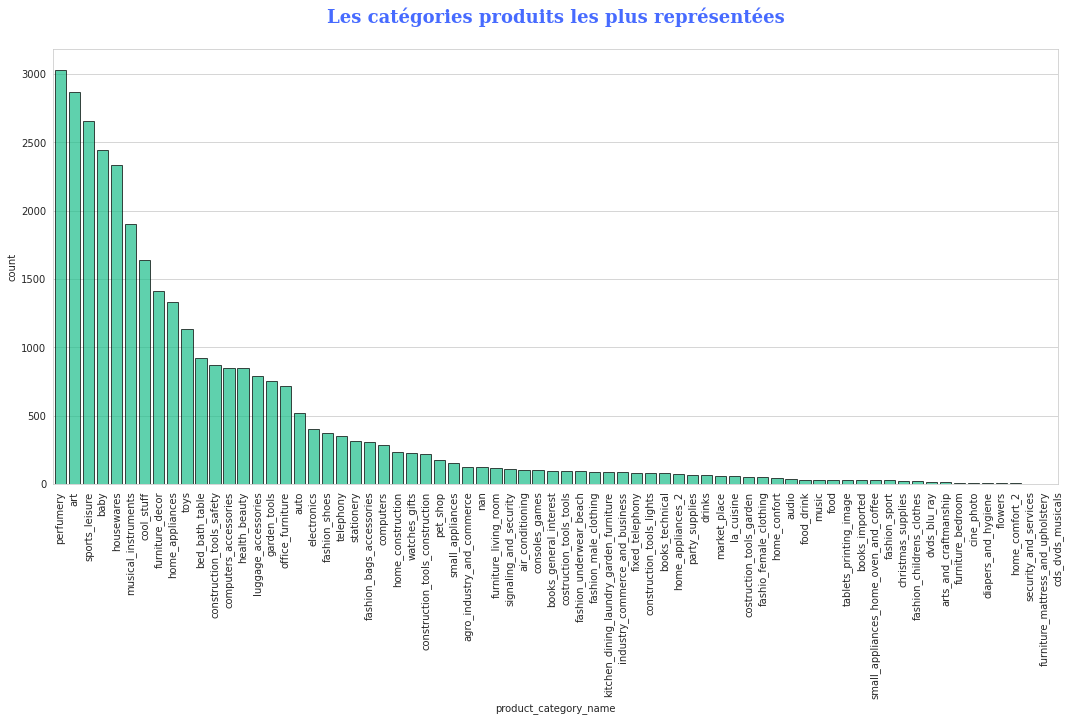

In [ ]:
# Plot categories count in dataset
sns.set_style("whitegrid")
font_title = {"family": "serif",
              "color":  "#476bff",
              "weight": "bold",
              "size": 18}

fig = plt.figure(figsize=(18, 8))
sns.countplot(data=products, x="product_category_name",
              edgecolor="black",
              color="#00d994", alpha=0.7,
              order = products['product_category_name'].value_counts().index)
plt.xticks(range(0, products["product_category_name"].nunique()+1),
           products["product_category_name"].unique(),
           rotation=90)
plt.title(f"Les catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

### Commandes et clients

Nous allons regrouper les données de lignes de commandes, d'entêtes de commandes et de données clients dans un unique dataframe.

In [ ]:
order_items = pd.merge(order_items, orders,
                       how="left",
                       on="order_id")

del_features_list = ["seller_id", "shipping_limit_date",
                     "order_approved_at",
                     "order_delivered_carrier_date",
                     "order_estimated_delivery_date"]
order_items.drop(del_features_list,
                 axis=1,
                 inplace=True)
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31


Regardons les différents statuts de commande pour ne conserver que les commandes qui ne sont pas "en cours".

In [ ]:
order_items.groupby(by="order_status").sum()["order_item_id"]

order_status
approved            4
canceled          704
delivered      132036
invoiced          435
processing        455
shipped          1294
unavailable         8
Name: order_item_id, dtype: int64

Nous conserverons les lignes typées "delivered".

In [ ]:
order_items = order_items[order_items["order_status"] == "delivered"]

Nous pouvons également vérifier l'évolution du nombre de commandes passées par jour sur le site E-Commerce :

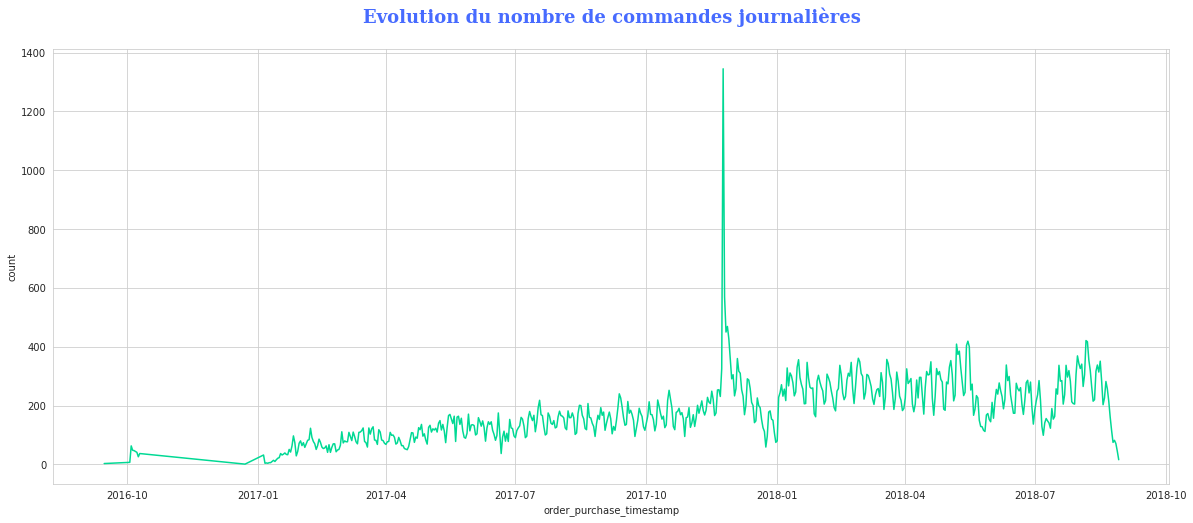

In [ ]:
orders_per_days = order_items.groupby(order_items["order_purchase_timestamp"]\
                                      .astype('datetime64[ns]').dt.date)\
                                    .count()["order_id"]
fig = plt.figure(figsize=(20, 8))
ax = orders_per_days.plot(color="#00d994")
ax.set_ylabel("count")
plt.title(f"Evolution du nombre de commandes journalières\n",
          fontdict=font_title)
plt.show()

On remarque un pic anormal autour de Novembre / Décembre 2017 (ce qui peut être un pic correspondant aux cadeaux de fin d'année) ainsi qu'un plateau sans commandes entre Octobre 2016 et Janvier 2017.

Nous allons modifier les types de données en datetime pour les colonnes temporelles.

In [ ]:
# Modify object cols in timestamp format
datetime_cols = ["order_purchase_timestamp", "order_delivered_customer_date"]
for col in datetime_cols:
    order_items[col] = order_items[col].astype('datetime64[ns]')
order_items.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 112649
Data columns (total 9 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_delivered_customer_date  110189 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 8.4+ MB


Nous pouvons également regarder la répartition du nombre de commandes par mois, jour de la semaine ou heure de la journée :

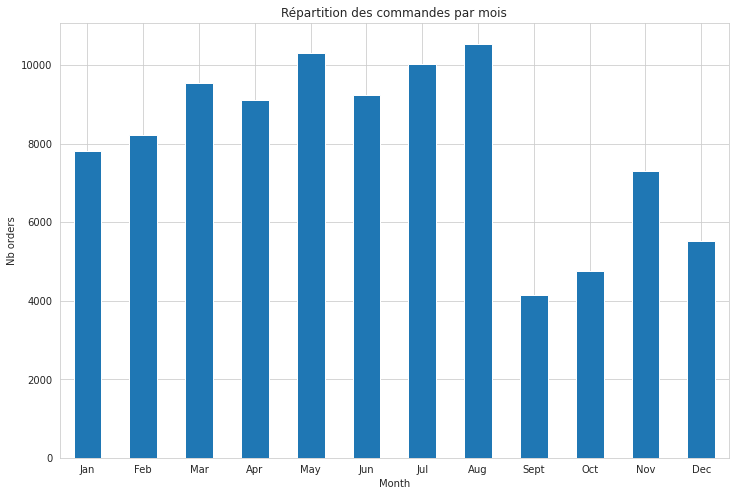

In [ ]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.month)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par mois",
          ylabel="Nb orders",
          xlabel="Month",
          legend=False)
plt.xticks(np.arange(0,12), ['Jan','Feb','Mar','Apr','May','Jun',
                             'Jul','Aug','Sept','Oct','Nov','Dec'], 
           rotation='horizontal')
plt.show()

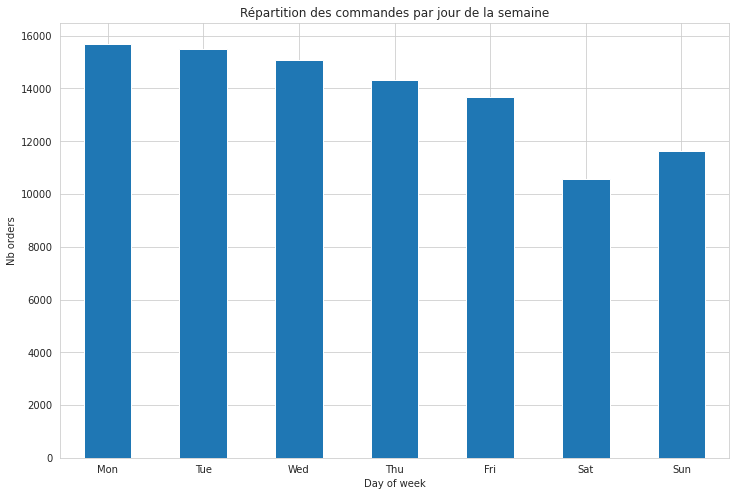

In [ ]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.dayofweek)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par jour de la semaine",
          ylabel="Nb orders",
          xlabel="Day of week",
          legend=False)
plt.xticks(np.arange(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation='horizontal')
plt.show()

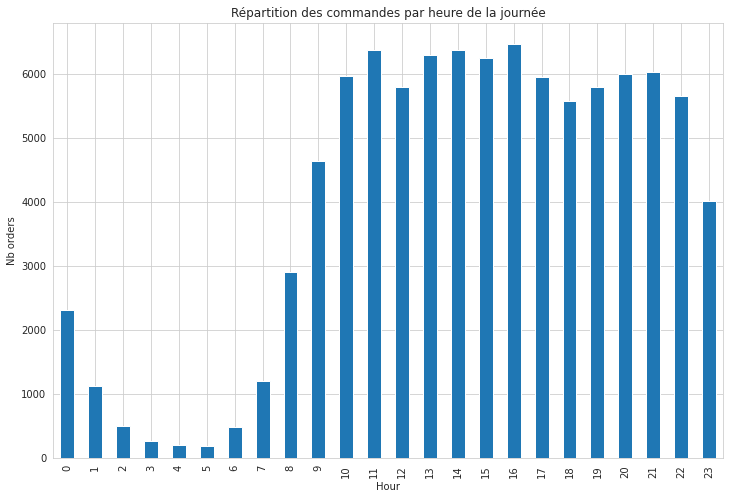

In [ ]:
order_items.groupby(order_items['order_purchase_timestamp'].dt.hour)\
    .agg({"order_id": "nunique"})\
    .plot(figsize=(12,8), kind="bar",
          title="Répartition des commandes par heure de la journée",
          ylabel="Nb orders",
          xlabel="Hour",
          legend=False)
plt.show()

On remarque les plus gros écart sur les données mensuelles. Vérifions les variances de chiffre d'affaire sur les mois de l'années

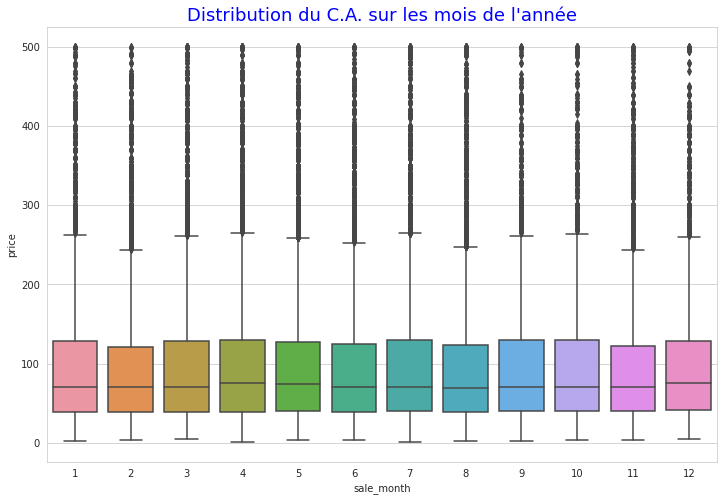

In [ ]:
order_items["sale_month"] = order_items['order_purchase_timestamp'].dt.month
fig = plt.figure(figsize=(12,8))
sns.boxplot(data=order_items[order_items.price < 500], x="sale_month", y="price")
plt.title("Distribution du C.A. sur les mois de l'année", fontsize=18, color="b")
plt.show()

Les médianes et variances restent très proche sur les différents mois de l'année. Nous intégrerons tout de même cette donnée pour le moment mais il sera judicieux de regarder l'évolution de cette distribution pour l'intégrer dans le cadre du contrat de maintenance.

Pour le dataset des paiements, nous allons créer de nouvelles variables à savoir :

* Le nombre de moyens de paiement différents utilisés sur la commande.
* Le nombre d'échéances totales de la commande.

In [ ]:
group_payments = order_payments.groupby(by="order_id").agg(
    {"payment_sequential": 'count',
     "payment_installments": 'sum'})

order_items = pd.merge(order_items, group_payments,
                       how="left",
                       on="order_id")
order_items = order_items.rename(columns={
    "payment_sequential": "nb_payment_sequential",
    "payment_installments": "sum_payment_installments"})
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,1.0,2.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,1.0,3.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,1.0,2.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,1.0,3.0


Nous allons également vérifier la répartition des moyens de paiement utilisés pour décider si cette information est importante ou non dans les analyses :

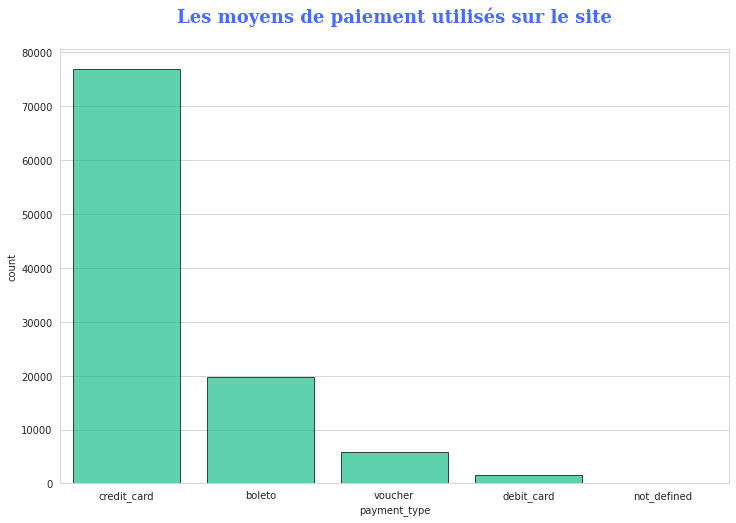

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.countplot(data=order_payments, x="payment_type",
              edgecolor="black",
              color="#00d994", alpha=0.7)
plt.title(f"Les moyens de paiement utilisés sur le site\n",
          fontdict=font_title)
plt.show()

On remarque que 80% des paiements environ sont réalisés en carte bancaire. Nous ne prendrons donc pas en considération cette variable dans nos explorations.

Pour les avis clients, nous allons également créer une nouvelle variable qui indiquera seulement si oui ou non la commande a été notée (True or False) et une seconde variable qui reprendra la note attribuée.

In [ ]:
group_reviews = order_reviews.groupby("order_id").agg({
    "review_id": "count",
    "review_score": "mean"})

order_items = pd.merge(order_items, group_reviews,
                       how="left",
                       on="order_id")
order_items = order_items.rename(columns={
    "review_id": "is_reviewed"})
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,1.0,2.0,1.0,5.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,1.0,3.0,1.0,4.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1.0,5.0,1.0,5.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,1.0,2.0,1.0,4.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,1.0,3.0,1.0,5.0


In [ ]:
order_items["is_reviewed"] = np.where(order_items["is_reviewed"] == 1,
                                      True, False)

Nous pouvons à présent projeter la répartion des notes attribuées aux commandes du site :

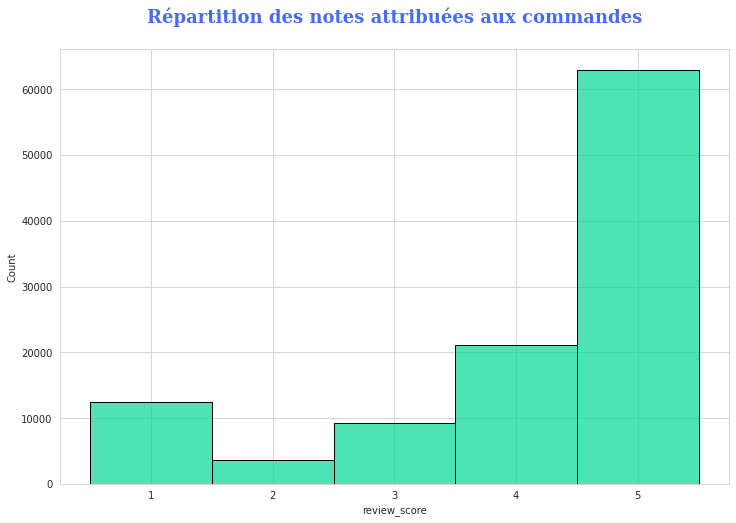

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=order_items, x="review_score", 
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.title(f"Répartition des notes attribuées aux commandes\n",
          fontdict=font_title)
plt.show()

Il nous reste à réaliser la jointure sur le fichier clients :

In [ ]:
order_items = pd.merge(order_items, customers,
                       how="left",
                       on="customer_id")
order_items.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,nb_payment_sequential,sum_payment_installments,is_reviewed,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,1.0,2.0,True,5.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,1.0,3.0,True,4.0,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,1.0,5.0,True,5.0,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,1.0,2.0,True,4.0,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,1.0,3.0,True,5.0,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP


et enfin créer le dataset global en réalisant la jointure avec les produits / catégories :

In [ ]:
data = pd.merge(order_items, products,
               how="left",
               on="product_id")
data.head(5)

,order_id,order_item_id,product_id,price,freight_value,customer_id,order_status,order_purchase_timestamp,order_delivered_customer_date,sale_month,...,is_reviewed,review_score,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,58.90,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-20 23:43:48,9,...,True,5.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,58.0,598.0,4.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,239.90,19.93,f6dd3ec061db4e3987629fe6b26e5cce,delivered,2017-04-26 10:53:06,2017-05-12 16:04:24,4,...,True,4.0,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,56.0,239.0,2.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,199.00,17.87,6489ae5e4333f3693df5ad4372dab6d3,delivered,2018-01-14 14:33:31,2018-01-22 13:19:16,1,...,True,5.0,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,59.0,695.0,2.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,12.99,12.79,d4eb9395c8c0431ee92fce09860c5a06,delivered,2018-08-08 10:00:35,2018-08-14 13:32:39,8,...,True,4.0,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,42.0,480.0,1.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,199.90,18.14,58dbd0b2d70206bf40e62cd34e84d795,delivered,2017-02-04 13:57:51,2017-03-01 16:42:31,2,...,True,5.0,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,59.0,409.0,1.0,garden_tools


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110197 entries, 0 to 110196
Data columns (total 22 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       110197 non-null  object        
 1   order_item_id                  110197 non-null  int64         
 2   product_id                     110197 non-null  object        
 3   price                          110197 non-null  float64       
 4   freight_value                  110197 non-null  float64       
 5   customer_id                    110197 non-null  object        
 6   order_status                   110197 non-null  object        
 7   order_purchase_timestamp       110197 non-null  datetime64[ns]
 8   order_delivered_customer_date  110189 non-null  datetime64[ns]
 9   sale_month                     110197 non-null  int64         
 10  nb_payment_sequential          110194 non-null  float64       
 11  

# Feature engineering en fonction du client

Maintenant que nous avons notre dataset étendu, nous allons centrer les données obtenues sur le client et non sur les commandes en créant de nouvelles variables. Comme nous l'avons vu précédement, l'identifiant unique du client est contenu dans la variable customer_unique_id.

Commençons par créer une variable contenant le délai le livraison de chaque commande (et suppression de la variable order_delivered_customer_date) :

In [ ]:
data["delivery_delta_days"] = (data.order_delivered_customer_date
                               - data.order_purchase_timestamp)\
                              .dt.round('1d').dt.days
data.drop("order_delivered_customer_date", axis=1, inplace=True)

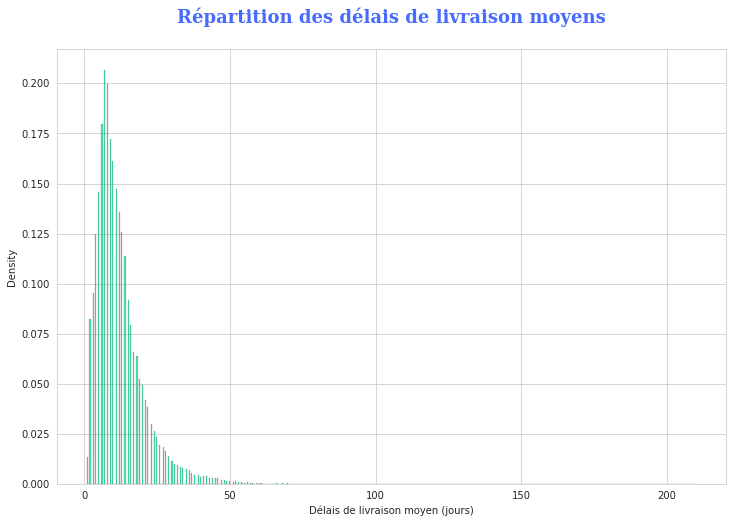

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="delivery_delta_days",
             stat="density",
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Délais de livraison moyen (jours)")
plt.title(f"Répartition des délais de livraison moyens\n",
          fontdict=font_title)
plt.show()

Autre variable à créer, la catégorie de produit de niveau 1. En effet, le jeu de données compte plus de 70 catégories différentes (ce qui peut poser problème pour un encodage lors des preprocessing). Nous allons donc devoir regrouper plusieurs de ces catégorie dans une catégorie de niveau supérieur.

Pour cela, nous allons nous baser sur les catégories principales des sites de vente en ligne:

* Fashion, clothing and accessories
* Health and Beauty
* Toys and baby equipment
* Books, CDs and other physical media
* Groceries, food and drink
* Technology (including phones and computers)
* Home and furniture
* Flowers and gifts
* Other
* et nous ajoutons la catégorie sport
Nous allons devoir les attribuer manuellement :

In [ ]:
data['product_category'] = np.where((data['product_category_name'].str.contains("fashio|luggage")==True),
                                    'fashion_clothing_accessories',
                           np.where((data['product_category_name'].str.contains("health|beauty|perfum")==True),
                                    'health_beauty',
                           np.where((data['product_category_name'].str.contains("toy|baby|diaper")==True),
                                     'toys_baby',
                           np.where((data['product_category_name'].str.contains("book|cd|dvd|media")==True),
                                     'books_cds_media',
                           np.where((data['product_category_name'].str.contains("grocer|food|drink")==True), 
                                     'groceries_food_drink',
                           np.where((data['product_category_name'].str.contains("phon|compu|tablet|electro|consol")==True), 
                                     'technology',
                           np.where((data['product_category_name'].str.contains("home|furnitur|garden|bath|house|applianc")==True), 
                                                                                          'home_furniture',
                           np.where((data['product_category_name'].str.contains("flow|gift|stuff")==True),
                                     'flowers_gifts',
                           np.where((data['product_category_name'].str.contains("sport")==True),
                                     'sport',
                                     'other')))))))))

In [ ]:
# drop product_category_name column
data.drop("product_category_name", axis=1, inplace=True)

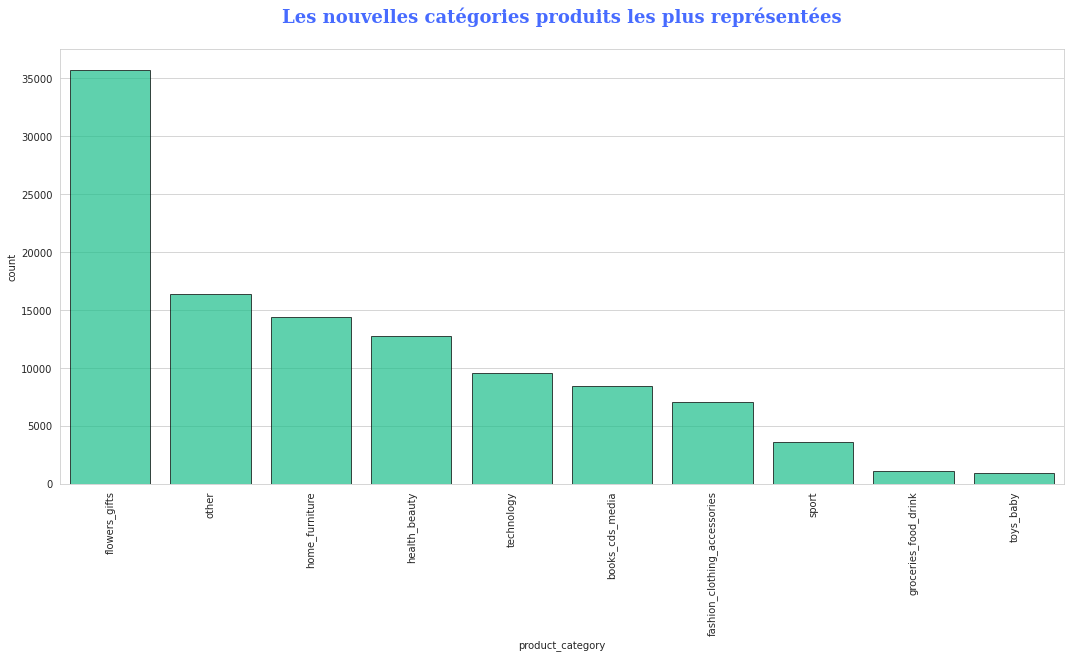

In [ ]:
# Plot categories count in dataset
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data, x="product_category",
              edgecolor="black",
              color="#00d994", alpha=0.7,
              order = data['product_category'].value_counts().index)
plt.xticks(range(0, data["product_category"].nunique()),
           data["product_category"].unique(),
           rotation=90)
plt.title(f"Les nouvelles catégories produits les plus représentées\n",
          fontdict=font_title)
plt.show()

A présent, nous pouvons regarder la répartition du nombre de commandes moyen par client :

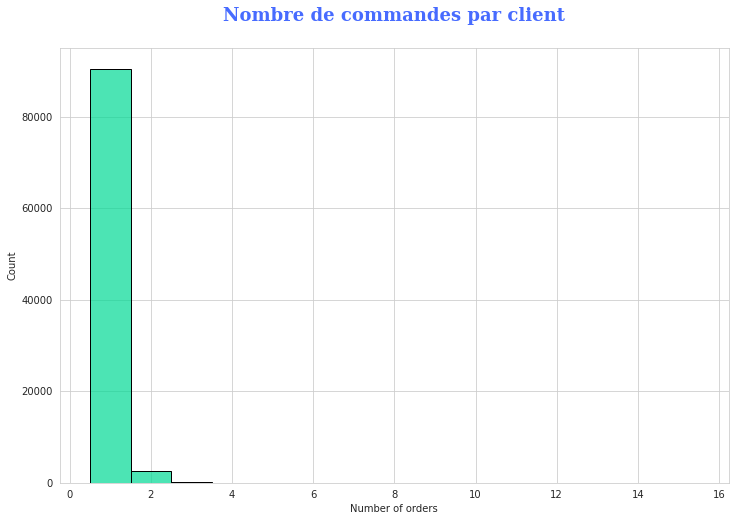

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data.groupby("customer_unique_id").agg({"order_id": "nunique"}),
             x="order_id",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Number of orders")
plt.title(f"Nombre de commandes par client\n",
          fontdict=font_title)
plt.show()

La majeure partie des clients n'ont passé qu'une seule commande. Il sera donc compliqué d'établir un classement de leur catégorie produit préférée. Nous allons donc créer une variable par catégorie produit pour y dispatcher le nombre de produits achetés sur les commandes passées.
Ensuite, nous calculerons le ratio du nombre de produits par catégorie sur le nombre de produits total acheté par le client.

In [ ]:
categories_customers = data.groupby(["customer_unique_id", "product_category"])\
                        .agg({"order_item_id": "count"}).unstack()
categories_customers.columns = categories_customers.columns.droplevel(0)
categories_customers.fillna(0, inplace=True)
categories_customers["total_items"] = categories_customers.sum(axis=1)

# ratio of total items
for col in categories_customers.columns:
    if (col != "total_items"):
        categories_customers[col] = (categories_customers[col]/categories_customers["total_items"])

categories_customers.reset_index(inplace=True)
categories_customers.head(5)

product_category,customer_unique_id,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items
0,0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0000f46a3911fa3c0805444483337064,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,0004aac84e0df4da2b147fca70cf8255,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


Nous allons ensuite calculer le nombre moyen d'articles par commande pour chaque client :

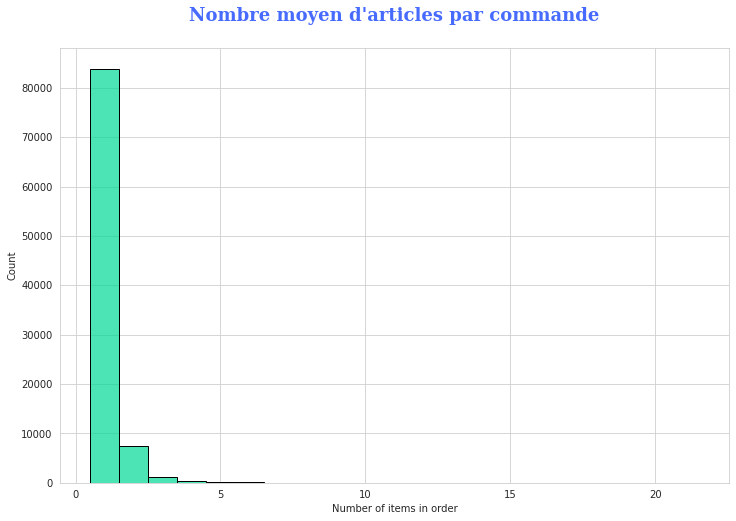

In [ ]:
products_per_order = data.groupby(["customer_unique_id", "order_id"])\
                        .agg({"order_item_id": "count"})
products_per_order = products_per_order.groupby("customer_unique_id")\
                        .agg({"order_item_id": "mean"})

# Plot density of number items in order
fig = plt.figure(figsize=(12, 8))
sns.histplot(data = products_per_order,
             x="order_item_id",
             discrete=True,
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Number of items in order")
plt.title(f"Nombre moyen d'articles par commande\n",
          fontdict=font_title)
plt.show()

A présent, nous allons calculer le nombre de jours écoulés entre la première et la dernière commande. Nous ramènerons ensuite ce délai au nombre de commande du client.

In [ ]:
from datetime import datetime
recurencies = data.groupby("customer_unique_id")\
                .agg({"order_purchase_timestamp": ["min","max"]})
recurencies.columns = recurencies.columns.droplevel(0)

# Max date in dataset
max_date = data["order_purchase_timestamp"].max()

# Recency
ref_date = datetime.strptime('2019-01-01', "%Y-%m-%d")
recurencies["recency"] = [(ref_date - y[0]).round('1d').days if y[1] != y[0] 
                                    else (ref_date - y[0]).round('1d').days 
                                    for x,y in recurencies.iterrows()]
# Delay from the last order
recurencies["order_total_delay"] = [(y[1] - y[0]).round('1d').days if y[1] != y[0] 
                                    else (max_date - y[0]).round('1d').days 
                                    for x,y in recurencies.iterrows()]
recurencies.drop(["min", "max"], axis=1, inplace=True)
recurencies.head(5)

,recency,order_total_delay
customer_unique_id,,
0000366f3b9a7992bf8c76cfdf3221e2,236,111
0000b849f77a49e4a4ce2b2a4ca5be3f,239,114
0000f46a3911fa3c0805444483337064,661,537
0000f6ccb0745a6a4b88665a16c9f078,445,321
0004aac84e0df4da2b147fca70cf8255,412,288


In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.histplot(data=data, x="recency",
             stat="density",
             edgecolor="black",
             color="#00d994", alpha=0.7)
plt.xlabel("Récence (jours)")
plt.title(f"Récence de la dernière commande\n",
          fontdict=font_title)
plt.show()

# Création du dataset clients 

In [ ]:
# Group by customers with sum or mean
data = data.groupby("customer_unique_id")\
            .agg({"order_id": "nunique",
                  "price": "sum",
                  "freight_value": "sum",
                  "nb_payment_sequential": "mean", 
                  "sum_payment_installments": "mean", 
                  "review_score": "mean",
                  "delivery_delta_days": "mean",
                  "sale_month": lambda x:x.value_counts().index[0]})

# Rename columns
data = data.rename(columns={"order_id": "nb_orders",
                            "price": "total_spend",
                            "freight_value": "total_freight",
                            "nb_payment_sequential": "mean_payment_sequential",
                            "sum_payment_installments": "mean_payment_installments",
                            "review_score": "mean_review_score",
                            "delivery_delta_days": "mean_delivery_days",
                            "sale_month": "favorite_sale_month"})

# Merge with other calculated features
data = pd.merge(data, categories_customers,
                how="left",
                on="customer_unique_id")

data = pd.merge(data, products_per_order,
                how="left",
                on="customer_unique_id")\
        .rename(columns={"order_item_id": "mean_nb_items"})

data = pd.merge(data, recurencies,
                how="left",
                on="customer_unique_id")

data.head(6)

,customer_unique_id,nb_orders,total_spend,total_freight,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,...,health_beauty,home_furniture,other,sport,technology,toys_baby,total_items,mean_nb_items,recency,order_total_delay
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,1.0,8.0,5.0,6.0,5,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,236,111
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,1.0,1.0,4.0,3.0,5,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,239,114
2,0000f46a3911fa3c0805444483337064,1,69.00,17.22,1.0,8.0,3.0,26.0,3,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,661,537
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,1.0,4.0,4.0,20.0,10,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,445,321
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,1.0,6.0,5.0,13.0,11,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,412,288
5,0004bd2a26a76fe21f786e4fbd80607f,1,154.00,12.98,1.0,8.0,4.0,2.0,4,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,270,146


Comme énoncé précédemment, nous allons ramener le délais des commandes client en fonction du nombre de commandes pour obtenir le délai moyen entre plusieurs achats :

In [ ]:
data["order_total_delay"] = data["order_total_delay"] / data["nb_orders"]
data = data.rename(columns={"order_total_delay": "order_mean_delay"})

Il nous reste à présent à calculer quelques dernières variables plus représentatives :

* Le ratio fret / total commande
* le prix moyen par commande

In [ ]:
data["freight_ratio"] = round(data["total_freight"] / (data["total_spend"] + data["total_freight"]),2)
data["mean_price_order"] = round(data["total_spend"] / data["nb_orders"],2)
data["total_spend"] = (data["total_spend"] + data["total_freight"])
data.drop("total_freight", axis=1, inplace=True)

Enfin, nous allons ajouter les données de localisation des clients :

In [ ]:
customers.drop("customer_id", axis=1, inplace=True)
# Select the most frequents values for each customer
customers_info = customers.groupby("customer_unique_id").agg(lambda x:x.value_counts().index[0])
data = pd.merge(data, customers_info,
                how="left",
                on="customer_unique_id")

# Exploration du dataset client¶

Nous avons à présent notre dataset complété pour la segmentation de la clientèle. Nous allons faire une rapide exploration de ces données :

In [ ]:
data.head(5)

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,toys_baby,total_items,mean_nb_items,recency,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state
0,0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,0.0,0.0,...,0.0,1.0,1.0,236,111.0,0.08,129.90,7787,cajamar,SP
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,0.0,0.0,...,0.0,1.0,1.0,239,114.0,0.30,18.90,6053,osasco,SP
2,0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,0.0,0.0,...,0.0,1.0,1.0,661,537.0,0.20,69.00,88115,sao jose,SC
3,0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,0.0,0.0,...,0.0,1.0,1.0,445,321.0,0.40,25.99,66812,belem,PA
4,0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,0.0,0.0,...,0.0,1.0,1.0,412,288.0,0.09,180.00,18040,sorocaba,SP


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93358 entries, 0 to 93357
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   customer_unique_id            93358 non-null  object 
 1   nb_orders                     93358 non-null  int64  
 2   total_spend                   93358 non-null  float64
 3   mean_payment_sequential       93357 non-null  float64
 4   mean_payment_installments     93357 non-null  float64
 5   mean_review_score             92755 non-null  float64
 6   mean_delivery_days            93350 non-null  float64
 7   favorite_sale_month           93358 non-null  int64  
 8   books_cds_media               93358 non-null  float64
 9   fashion_clothing_accessories  93358 non-null  float64
 10  flowers_gifts                 93358 non-null  float64
 11  groceries_food_drink          93358 non-null  float64
 12  health_beauty                 93358 non-null  float64
 13  h

Seulement 3 variables contiennent des valeurs nulles. Nous allons donc les compléter par les valeurs les plus fréquentes :

In [ ]:
# Find features to fill and fillna with mode
features_to_fill = data.isnull().sum()
features_to_fill = list(features_to_fill[features_to_fill.values > 0].index)

for f in features_to_fill:
    data[f] = data[f].fillna(data[f].mode()[0])
    print(f, data[f].mode()[0])

mean_payment_sequential 1.0
mean_payment_installments 1.0
mean_review_score 5.0
mean_delivery_days 7.0


In [ ]:
data.describe()

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,sport,technology,toys_baby,total_items,mean_nb_items,recency,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix
count,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,...,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000,93358.000000
mean,1.033420,165.168210,1.043872,2.965951,4.158806,12.524327,6.034759,0.009085,0.034082,0.094412,...,0.077026,0.152034,0.068452,1.180370,1.139531,364.394428,232.502018,0.208141,137.508262,35243.998340
std,0.209097,226.292101,0.364435,2.717719,1.278290,9.550578,3.226430,0.094527,0.180035,0.290952,...,0.265228,0.357663,0.251017,0.620857,0.527075,153.100039,154.187659,0.124892,209.860281,29843.212881
min,1.000000,9.590000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,124.000000,0.000000,0.000000,0.850000,1003.000000
25%,1.000000,63.010000,1.000000,1.000000,4.000000,7.000000,3.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,240.000000,108.000000,0.120000,46.000000,11410.000000
50%,1.000000,107.780000,1.000000,2.000000,5.000000,10.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,346.000000,212.000000,0.180000,86.990000,24455.000000
75%,1.000000,182.510000,1.000000,4.000000,5.000000,16.000000,8.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.000000,474.000000,342.000000,0.270000,149.900000,59075.000000
max,15.000000,13664.080000,26.000000,26.000000,5.000000,210.000000,12.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,24.000000,21.000000,837.000000,713.000000,0.960000,13440.000000,99980.000000


On peut voir également dans cette description qu'une commande est chiffrée à plus de 13 000 dollars. Nous allons vérifier cette commande atypique :

In [ ]:
data[data["mean_price_order"] == data["mean_price_order"].max()]

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,toys_baby,total_items,mean_nb_items,recency,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state
3724,0a0a92112bd4c708ca5fde585afaa872,1,13664.08,1.0,1.0,1.0,18.0,9,0.0,0.0,...,0.0,8.0,8.0,458,334.0,0.02,13440.0,20080,rio de janeiro,RJ


Cette commande contient 8 articles technologiques pour un montant de 13 000 dollars. C'est atypique certes, mais ce n'est pas pour autant une donnée abérrante. Nous la conservons donc.

Regardons la dispersion des montants moyen de commandes en fonction du nombre d'articles pour tenter de repérer d'autres anomalies :

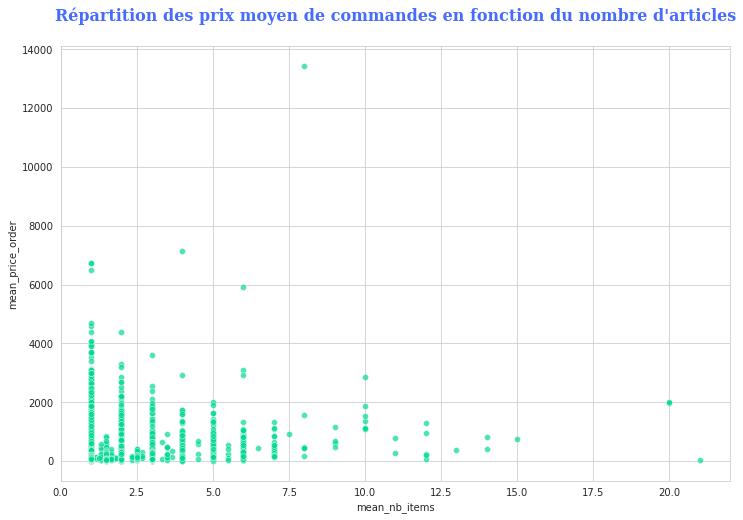

In [ ]:
fig = plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, y="mean_price_order", x="mean_nb_items",
                color="#00d994", alpha=0.7)
plt.title(f"Répartition des prix moyen de commandes en fonction du nombre d'articles\n",
          fontdict=font_title, fontsize=16)
plt.show()

Une commande de plus de 20 articles est affichée pour une somme de près de 0 :

In [ ]:
data[data["mean_nb_items"] > 20]

,customer_unique_id,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,...,toys_baby,total_items,mean_nb_items,recency,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state
25309,4546caea018ad8c692964e3382debd19,1,196.17,1.0,2.0,1.0,15.0,7,0.0,0.0,...,0.0,21.0,21.0,533,409.0,0.84,31.8,5882,sao paulo,SP


Cette fois encore, c'est une valeur atypique mais pas abérrante.

## Les différents états du fichier client :

Ici, nous allons regader d'où viennent les clients et si cette localisation a un impact sur les ventes.

In [ ]:
data["customer_state"].unique()

array(['SP', 'SC', 'PA', 'PR', 'RJ', 'MA', 'ES', 'RS', 'MG', 'GO', 'DF',
       'BA', 'MT', 'SE', 'TO', 'PE', 'CE', 'AL', 'AC', 'PI', 'PB', 'RN',
       'AM', 'MS', 'AP', 'RO', 'RR'], dtype=object)

Les codes états ne sont pas très parlant. Nous allons donc utiliser Wikipedia pour modifier les codes états par leur nom :

In [ ]:
!pip3 install lxml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
wiki_url = "https://en.wikipedia.org/wiki/Federative_units_of_Brazil"
states_table = pd.read_html(wiki_url)[3].set_index("Code")
states_table.head(6)

,Flag and name,Capital,Largest city,Area(km2)[20],Population(2019)[21],"Density (perkm2, 2019)","GDP (R$millions, 2016)[22]",HDI(2017)[23]
Code,,,,,,,,
AC,Acre,Rio Branco,Rio Branco,164123,880000,6.34,15000,0.719
AL,Alagoas,Maceió,Maceió,27779,3334000,125.52,50000,0.683
AP,Amapá,Macapá,Macapá,142829,838000,2.63,12000,0.740
AM,Amazonas,Manaus,Manaus,1559159,4147000,2.58,94000,0.733
BA,Bahia,Salvador,Salvador,564733,14897000,30.52,262000,0.714
CE,Ceará,Fortaleza,Fortaleza,148921,8843000,60.33,143000,0.735


In [ ]:
data = pd.merge(data.reset_index(), states_table[["Flag and name"]],
                how="left",
                left_on="customer_state",
                right_on="Code")
data.drop("customer_state", axis=1, inplace=True)
data = data.rename(columns={"Flag and name": "customer_state"})

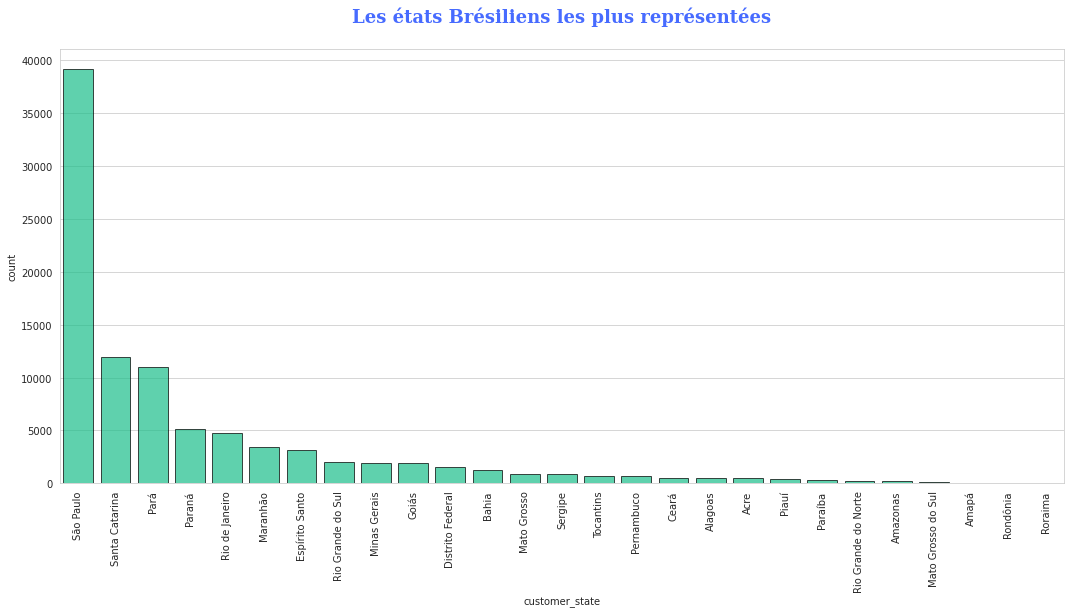

In [ ]:
# Countplot of states repartition
fig = plt.figure(figsize=(18, 8))
sns.countplot(data=data, x="customer_state",
              edgecolor="black",
              color="#00d994", alpha=0.7,
             order = data['customer_state'].value_counts().index)
plt.xticks(range(0, data["customer_state"].nunique()),
           data["customer_state"].unique(),
           rotation=90)
plt.title(f"Les états Brésiliens les plus représentés\n",
          fontdict=font_title)
plt.show()

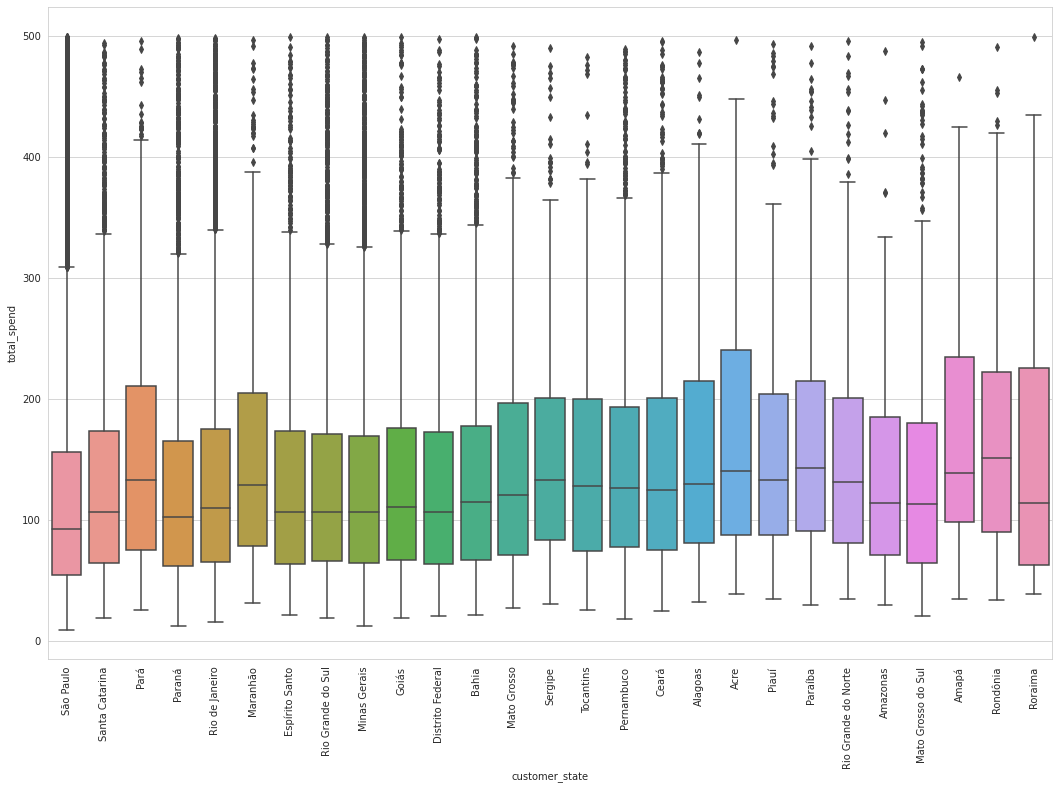

In [ ]:
# Boxplots of total spend by state
fig = plt.figure(figsize=(18,12))
sns.boxplot(x="customer_state", y="total_spend", 
            data=data[data["total_spend"]<500])
plt.xticks(rotation=90)
plt.show()

On voit dans ces boxplots que l'état du client a un impact faible sur les variances et médianes des dépenses sur le site.

Afin d'utiliser une variable de localisation encodable sans impact négatif sur nos modélisation, nous allons calculer la distance Haversine entre l'état du client (moyenne des latitudes et longitudes de l'état) et le siège de Olist :

In [ ]:
state_location = geolocation.groupby("geolocation_state").mean()
state_location = pd.merge(states_table[["Flag and name"]].reset_index(), 
                          state_location, 
                          right_on="geolocation_state", 
                          left_on="Code", 
                          how="left")
state_location = state_location[["Flag and name", "geolocation_lat", "geolocation_lng"]]

# Olist location
olist_lat = -25.43045
olist_lon = -49.29207

In [ ]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [ ]:
# Haversine distance between centre state and Olist office
state_location['harvesine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y) 
                              for x, y in zip(state_location.geolocation_lat, 
                                              state_location.geolocation_lng)]

In [ ]:
data = pd.merge(data, state_location[["Flag and name", "harvesine_distance"]],
         how="left",
         left_on="customer_state",
         right_on="Flag and name")
data.drop("index", axis=1, inplace=True)
data.set_index("customer_unique_id", inplace=True)
data.head(6)

,nb_orders,total_spend,mean_payment_sequential,mean_payment_installments,mean_review_score,mean_delivery_days,favorite_sale_month,books_cds_media,fashion_clothing_accessories,flowers_gifts,...,mean_nb_items,recency,order_mean_delay,freight_ratio,mean_price_order,customer_zip_code_prefix,customer_city,customer_state,Flag and name,harvesine_distance
customer_unique_id,,,,,,,,,,,,,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,1,141.90,1.0,8.0,5.0,6.0,5,0.0,0.0,0.0,...,1.0,236,111.0,0.08,129.90,7787,cajamar,São Paulo,São Paulo,209.713834
0000b849f77a49e4a4ce2b2a4ca5be3f,1,27.19,1.0,1.0,4.0,3.0,5,0.0,0.0,0.0,...,1.0,239,114.0,0.30,18.90,6053,osasco,São Paulo,São Paulo,209.713834
0000f46a3911fa3c0805444483337064,1,86.22,1.0,8.0,3.0,26.0,3,0.0,0.0,0.0,...,1.0,661,537.0,0.20,69.00,88115,sao jose,Santa Catarina,Santa Catarina,125.363853
0000f6ccb0745a6a4b88665a16c9f078,1,43.62,1.0,4.0,4.0,20.0,10,0.0,0.0,0.0,...,1.0,445,321.0,0.40,25.99,66812,belem,Pará,Pará,1574.231129
0004aac84e0df4da2b147fca70cf8255,1,196.89,1.0,6.0,5.0,13.0,11,0.0,0.0,0.0,...,1.0,412,288.0,0.09,180.00,18040,sorocaba,São Paulo,São Paulo,209.713834
0004bd2a26a76fe21f786e4fbd80607f,1,166.98,1.0,8.0,4.0,2.0,4,0.0,0.0,0.0,...,1.0,270,146.0,0.08,154.00,5036,sao paulo,São Paulo,São Paulo,209.713834


# Corrélations :

Nous allons à présent regarder s'il existe des corrélations linéaires fortes dans le jeu de données 

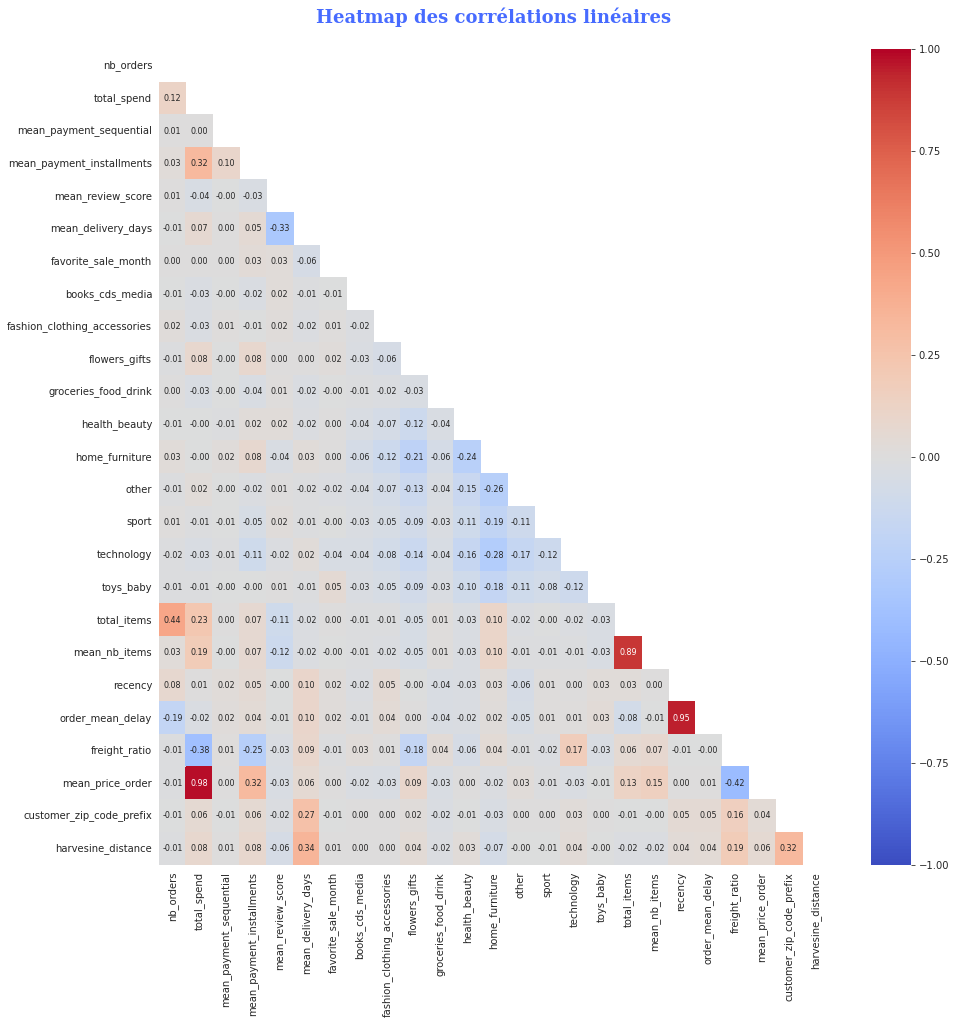

In [ ]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True,
                 vmin=-1, vmax=1,
                 fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, 
                 center=0, 
                 cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", 
          fontdict=font_title)
plt.show()

On remarque que le prix total est très fortement corrélé au prix moyen par commande (idem pour le nombre d'articles moyen et le nombre d'articles total). Cela est dû au fait que la majorité des clients n'ont commandé qu'une seule fois. Cette variable sera donc moins corrélée au fil du temps.

### Export du dataset final pour classification non-supervisée

A partir de toutes ces features, nous allons modéliser les données pour une classification non-supervisée avec plusieurs modèles. Ces étapes seront réalisées dans un Notebook  séparé 

In [ ]:
data.to_csv(root_path + "olist-customers-segmentation.csv")